In [1]:
# %load /Users/Yong/Dropbox/nb_common_funcs.py
%matplotlib inline
import numpy as np 
import os
import re
from glob import glob


from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

import astropy.constants as const
from astropy.constants import c as speed_of_light

Dwarf-QSO pair info

In [15]:
#gal_name = 'DDO190'
#gal_name_short = 'DDO190'
#qso_name = '2MASXJ14292507+4518318'

gal_name = 'Sextans B'
gal_name_short = 'SexB'
qso_name = 'SDSSJ095915.65+050355.1'
# dir that stores continuum normalized data 
dw_qso_dir = './data/dw_qso_spec/{}_{}/'.format(gal_name_short, qso_name)

In [16]:
dw_tb = Table.read('./data/zheng_dwarfcgm-survey_cut-mstar9.5-snr8-br200m.csv', format='ascii')
ind = (dw_tb['qso_hsla_name']==qso_name) & (dw_tb['gal_name']==gal_name) 
qso_rkpc = dw_tb['impact_para_kpc'][ind]
qso_snr = dw_tb['qso_hsla_snr'][ind]
dw_tb[ind]

References,gal_name,gal_ra_deg,gal_dec_deg,gal_vlsr_km/s,qso_hsla_name,qso_ra_deg,qso_dec_deg,impact_para_kpc,impact_para_err,qso_hsla_snr,qso_snr_stis,gal_z,gal_dmpc,d_err,d_ref,logM*,logM*_err,M*_ref,logM200m,logM200m_err,M200m_ref,logM200c,logM200c_err,M200c_ref,logMHI,logMHI_err,MHI_ref,logSFR_flg,logSFR(Msun/yr),logSFR_err,SFR_ref,R200m_kpc,R200m_err,R200c_kpc,R200c_err,Wr_flg_HI,Wr_HI,eWr_HI,logN_flg_HI,logN_HI,elogN_HI,Wr_flg_SiII,Wr_SiII,eWr_SiII,logN_flg_SiII,logN_SiII,elogN_SiII,Wr_flg_SiIII,Wr_SiIII,eWr_SiIII,logN_flg_SiIII,logN_SiIII,elogN_SiIII,Wr_flg_SiIV,Wr_SiIV,eWr_SiIV,logN_flg_SiIV,logN_SiIV,elogN_SiIV,Wr_flg_CII,Wr_CII,eWr_CII,logN_flg_CII,logN_CII,elogN_CII,Wr_flg_CIV,Wr_CIV,eWr_CIV,logN_flg_CIV,logN_CIV,elogN_CIV,Wr_flg_OVI,Wr_OVI,eWr_OVI,logN_flg_OVI,logN_OVI,elogN_OVI
str15,str23,float64,float64,float64,str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,str24,float64,float64,str3,float64,float64,str3,float64,float64,str17,str1,float64,float64,str19,float64,float64,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64,str8,float64,float64
NewObs/Archived,Sextans B,150.0004,5.3322,294.01,SDSSJ095915.65+050355.1,149.8152,5.0653,8.1,0.3,10.8,nan,nan,1.43,0.05,T16,7.56,0.07,Dale09+d_ref,10.52,0.04,M21,10.37,0.04,M21,7.57,0.03,H18+d_ref,=,-2.58,0.04,"FUV, Lee11",100.2,3.1,60.4,1.9,--,nan,nan,--,nan,nan,<=(1sig),17.0,nan,<=(1sig),12.02,nan,=,79.6,9.8,=,12.72,0.06,=,24.0,8.1,=,12.45,0.13,--,nan,nan,--,nan,nan,=,121.4,23.1,=,13.63,0.05,--,nan,nan,--,nan,nan


In [17]:
gal_ra = dw_tb['gal_ra_deg'][ind][0]
gal_dec = dw_tb['gal_dec_deg'][ind][0]
gal_vlsr = dw_tb['gal_vlsr_km/s'][ind][0]
gal_coord = SkyCoord(ra=gal_ra, dec=gal_dec, frame='icrs', unit=(u.deg, u.deg))

# change from vlsr to vhel 
from yztools.vhelio2vlsr import vhelio2vlsr_Westmeier 
vlsr_2_vhel = vhelio2vlsr_Westmeier(0, gal_coord.galactic.l.deg, 
                                    gal_coord.galactic.b.deg, 
                                    reverse=True, do_print=True)
gal_vhel = gal_vlsr+vlsr_2_vhel
gal_z = gal_vhel/(speed_of_light.to(u.km/u.s).value)
print("Reference (host galaxy) redshift: z={:.2e}, vhel={:.2f} km/s".format(gal_z, gal_vhel))

Input: vlsr=0.00 km/s, l_deg=233.2001, b_deg=43.7838
Output: vhelio=5.99 km/s
Reference (host galaxy) redshift: z=1.00e-03, vhel=300.00 km/s


Get line data 

In [18]:
ion_data = Table.read('/Users/Yong/Dropbox/GitRepo/yztools/llist/morton03.txt', format='ascii')

line_names_short = ['CII1334', 'CIV1548',  
                   'SiII1260', 'SiIII1206', 'SiIV1393']
line_fs_short = np.zeros(len(line_names_short))
line_lambdas_short = np.zeros(len(line_names_short))
for ll in range(len(line_names_short)):
    line_fs_short[ll] = ion_data['line_f'][ion_data['line_name']==line_names_short[ll]]
    line_lambdas_short[ll] = ion_data['line_lambda'][ion_data['line_name']==line_names_short[ll]]

Get AOD result 

In [19]:
# if this line has been processed, then use the previous vaod ranges
aod_dir = './data/aod/'
nbin = 'bin3'

ion_tb_temp = glob('{}/{}_{}_aod_{}.txt'.format(aod_dir, gal_name_short, qso_name, nbin))
print(ion_tb_temp)
if len(ion_tb_temp) != 0:
    print('Has AOD ranges: ')
    vaod_minmax = {}
    aod_tb = Table.read(ion_tb_temp[0], format='ascii')
    for ll, line_name in enumerate(aod_tb['line']): 
        vaod_minmax[line_name] = [aod_tb['vmin'][ll], aod_tb['vmax'][ll]]

vaod_minmax

['./data/aod//SexB_SDSSJ095915.65+050355.1_aod_bin3.txt']
Has AOD ranges: 


{'SiII1190': [-50.0, 50.0],
 'SiIII1206': [-50.0, 50.0],
 'SII1250': [-50.0, 50.0],
 'CII1334': [nan, nan],
 'SiII1193': [-50.0, 50.0],
 'SiIV1393': [-50.0, 50.0],
 'SII1253': [-50.0, 50.0],
 'CIV1548': [-90.0, 50.0],
 'SiII1260': [-50.0, 50.0],
 'SiIV1402': [-50.0, 50.0],
 'SII1259': [nan, nan],
 'CIV1550': [-90.0, 50.0],
 'SiII1526': [-50.0, 50.0],
 'AlII1670': [-50.0, 50.0]}

plot set up

In [20]:
# Various plotting functions 
def plt_vhel_flux_short(ax, vhel_arr, flux_arr, err_arr, iline, gal_vhel,  
                      vrange=[-300, 300], vaod_min=-50, 
                  vaod_max=50, ymin=-0.1, ymax=1.5, aod_text3='', aod_text4='', 
                  aod_text1='', aod_text2='', line_loc='top left'): 
    ax.step(vhel_arr, flux_arr, color='k', lw=0.7)
    ax.step(vhel_arr, err_arr, color='k', lw=0.7, alpha=0.5)
    ax_xmin = vrange[0]
    ax_xmax = vrange[1]
    ax.set_xlim(ax_xmin, ax_xmax)
    ax.hlines(1.0, ax_xmin, ax_xmax, ls=':', lw=0.7, color='k')
    ax.vlines(0, ymin, ymax, linestyle=':', lw=0.5, color=mw_color)
    ax.vlines(gal_vhel, ymin, ymax, linestyle=':', lw=0.5, color='r')
    if np.isfinite(vaod_min): 
        ax.fill_between([gal_vhel+vaod_min, gal_vhel+vaod_max], 
                        ymin, ymax, color=plt.cm.Greys(0.6), alpha=0.2, lw=0)
    ax.set_ylim(ymin, ymax)
    ax.tick_params('x', labelsize=fs-3)
    ax.tick_params('y', labelsize=fs-3)
    ax.set_xlabel(r'v$_{\rm helio}$ (km/s)', fontsize=fs)
    ax.set_title(iline, fontsize=fs, pad=0.2)
    ax.set_xticks([-200, 0, 200, 400])
    
    # add AOD measurements
    if iline in line_names_short: 
        text_color = 'm'
    else: 
        text_color = 'm'
    if len(aod_text1)>0: 
        xx = dv_left+(dv_right-dv_left)*0.4
        #xx = gal_vhel - 130
        #yy1, yy2, yy3 = 1.56, 1.38, 1.21
        yy1, yy2, yy3, yy4 = 1.59, 1.42, 1.25, 1.08 
        ax.text(xx, yy1, aod_text1, fontsize=fs-5, color=text_color)
        ax.text(xx, yy2, aod_text2, fontsize=fs-5, color=text_color)
        ax.text(xx, yy3, aod_text3, fontsize=fs-5, color=text_color)
        ax.text(xx, yy4, aod_text4, fontsize=fs-5, color=text_color)
        
    ax.minorticks_on()
    return ax, ax_xmin, ax_xmax

def annotate_lines_short(ax, ref_lambda, gal_labels, gal_vs, ymin, ymax, xmin, xmax, 
                   fs=6): 
    from yztools.llist.load_atomic_data import morton03
    ions = ['SiII', 'SiIII', 'SiIV', 'CII', 'CIV', 
             'SII', 'AlII']
    for ion in ions: 
        ion_info = morton03(ion)
        for i, line_lambda in enumerate(ion_info['lambda']):
            this_line_v = (line_lambda/ref_lambda-1)*speed_of_light.to(u.km/u.s).value
            for iv, ib in zip(gal_vs, gal_labels): 
                if (this_line_v+iv <= xmin) or (this_line_v+iv >= xmax): 
                    continue
                else: 
                    ax.vlines(this_line_v+iv, ymin, ymax, linestyle=':', color='k', 
                              alpha=0.7, lw=0.5)
                    if ib == 'MW': 
                        color = mw_color
                    else: 
                        color = gal_color
                    ax.text(this_line_v+iv, ymin+(ymax-ymin)*0.05+0.2, 
                            '{}-{}'.format(ib, ion_info['line_name'][i]), fontsize=fs, 
                            color=color, rotation=90)

In [21]:
mw_color = plt.cm.Greys(0.8)
gal_color = plt.cm.RdPu(0.7)
dv_left = -200 # velocity range to plot
dv_right = 600
line_loc = 'top left'

In [22]:
ionfile_temp = '{}/*_{}_{}_{}.txt'.format(dw_qso_dir, line_name, gal_name, nbin)
print(ionfile_temp)

./data/dw_qso_spec/SexB_SDSSJ095915.65+050355.1//*_AlII1670_Sextans B_bin3.txt


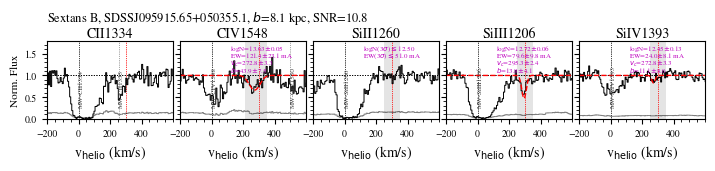

In [23]:
fig = plt.figure(figsize=(7, 1.5))
# fig = plt.figure(figsize=(3, 5.7))
ax_width = 0.18
ax_height = 0.52
ncol = 5   # number of plot panels 
fs = 10

axes = []
for ll in np.arange(len(line_names_short)):
    # print('yes')
    # line information 
    line_name = line_names_short[ll]
    ion, _, _ = re.split('(\d+)', line_name)
    line_lambda = line_lambdas_short[ll]
    ref_lambda = line_lambda # *(1+gal_z)
    vaod_min = vaod_minmax[line_name][0]
    vaod_max = vaod_minmax[line_name][1]
    
    # find the corresponding spectra 
    ionfile_temp = '{}/*_{}_{}_{}.txt'.format(dw_qso_dir, line_name, gal_name_short, nbin)
    #print(ionfile_temp)
    ionfiles = glob(ionfile_temp)
    #print(ionfile_temp, ionfiles)
    if len(ionfiles) == 1:
        # read spectra 
        line_spec = Table.read(ionfiles[0], format='ascii')
        line_wave = line_spec['Wave']
        line_flux = line_spec['NormFlux']
        line_err = line_spec['NormErr']
        line_vhel = (line_wave/line_lambda-1)*speed_of_light.to(u.km/u.s).value# line_spec['Vel']
        
        # plot the spectra in velocity/heliocentric frame 
        ax_v = fig.add_axes([0.055+(ax_width+0.01)*ll, 0.25, ax_width, ax_height])
        # ax_v = fig.add_subplot(6, 1, ll+1)
        axes.append(ax_v)
        
        # just plot the data first 
        plt_vhel_flux_short(ax_v, line_vhel, line_flux, line_err, 
                            line_name, gal_vhel, vrange=[dv_left, dv_right], 
                            vaod_min=np.nan, vaod_max=np.nan, 
                            ymin=0, ymax=1.8, line_loc=line_loc)
        
        # now add other labels 
        ind_aod = aod_tb['line'] == line_name
        
        #### if there is voigt file
        if qso_name in ['NGC-5548', 'PG0052+251']: 
            continue
        voigt_file = ionfiles[0].replace('bin3', 'bin3_voigt-comps')
        if os.path.isfile(voigt_file) & np.isfinite(vaod_min) & (gal_name != 'UGC06541'): 
            # print(voigt_file)
            voigt_tb = Table.read(voigt_file, format='ascii')
            voigt_wave = voigt_tb['wave']
            voigt_vhel = (voigt_wave/line_lambda-1)*speed_of_light.to(u.km/u.s).value
            indv = np.all([voigt_vhel>=dv_left, voigt_vhel<=dv_right], axis=0)
            
            # find corresponding Voigt measurement file 
            mod_file = glob('{}/{}_*{}*.mod.out.dat'.format(dw_qso_dir, qso_name, ion))[0]
            # print(mod_file)
            mod_tb = Table.read(mod_file, format='ascii')
            for icol in voigt_tb.colnames:
                if icol == 'wave':
                    continue
                else: 
                    comp_v = float(icol.split('_')[2])
                    if abs(comp_v - gal_vhel) < 30:
                        ax_v.plot(voigt_vhel[indv], voigt_tb[icol][indv], 
                                  color='r', lw=1, ls='--')
                        # add relevant information if it's related to the galaxy
                    
                        ind_abs = (mod_tb['ion'] == ion) & (abs(mod_tb['vhel']-comp_v)<2)
                        logN_abs = mod_tb['logN'][ind_abs][0]
                        elogN_abs = mod_tb['err_logN'][ind_abs][0]
                        v_abs = mod_tb['vhel'][ind_abs][0]
                        ev_abs = mod_tb['err_vhel'][ind_abs][0]
                        b_abs = mod_tb['b'][ind_abs][0]
                        eb_abs = mod_tb['err_b'][ind_abs][0]
                    
                        # plot the data 
                        aod_text1 = r'logN={:.2f}$\pm${:.2f}'.format(logN_abs, elogN_abs)
                        aod_text2 = r'EW{}{:.1f}$\pm${:.1f} mA'.format(aod_tb['flag'][ind_aod][0], 
                                                               aod_tb['Wr(mA)'][ind_aod][0], 
                                                               aod_tb['eWr(mA)'][ind_aod][0])
                        aod_text3 = r'$v_c$={:.1f}$\pm${:.1f}'.format(v_abs, ev_abs)
                        aod_text4 = r'$b$={:.1f}$\pm${:.1f}'.format(b_abs, eb_abs)
                        plt_vhel_flux_short(ax_v, line_vhel, line_flux+np.nan, line_err+np.nan, 
                                            line_name, gal_vhel, vrange=[dv_left, dv_right], 
                                            vaod_min=vaod_min, vaod_max=vaod_max, 
                                            ymin=0, ymax=1.8, aod_text1=aod_text1, 
                                            aod_text2=aod_text2, aod_text3=aod_text3, 
                                            aod_text4=aod_text4,
                                            line_loc=line_loc)
                    
        else: 
        ### otherwise use AOD #### 
            if aod_tb['flag'][ind_aod] == '<=(3sig)': 
                logN_3sig_val = aod_tb['logN(3sig)'][ind_aod][0]
                #logN_1sig_val = np.log10((10**logN_3sig_val)/3.)
                aod_text1 = r'logN(3$\sigma$)$\leq${:.2f}'.format(logN_3sig_val)
                
                ew_3sig_val = aod_tb['Wr(mA)(3sig)'][ind_aod][0]
                #ew_1sig_val = ew_3sig_val/3.
                aod_text2 = r'EW(3$\sigma$)$\leq${:.1f} mA'.format(ew_3sig_val)
            elif (aod_tb['flag'][ind_aod] == ' '*8) or (np.isnan(aod_tb['logN'][ind_aod])):
                aod_text1 = ''
                aod_text2 = ''
            else: 
                #print('here here here')
                # print(aod_tb[ind_aod])
                aod_text1 = r'logN{}{:.2f}$\pm${:.2f}'.format(aod_tb['flag'][ind_aod][0], 
                                                              aod_tb['logN'][ind_aod][0], 
                                                              aod_tb['elogN'][ind_aod][0])
                aod_text2 = r'EW{}{:.1f}$\pm${:.1f} mA'.format(aod_tb['flag'][ind_aod][0], 
                                                               aod_tb['Wr(mA)'][ind_aod][0], 
                                                               aod_tb['eWr(mA)'][ind_aod][0])
            aod_text3 = ''
            plt_vhel_flux_short(ax_v, line_vhel, line_flux+np.nan, line_err+np.nan, 
                                line_name, gal_vhel, vrange=[dv_left, dv_right], 
                                vaod_min=vaod_min, vaod_max=vaod_max, 
                                ymin=0, ymax=1.8, aod_text1=aod_text1, 
                                aod_text2=aod_text2, 
                                aod_text3=aod_text3, 
                                line_loc=line_loc)
        
        annotate_lines_short(ax_v, line_lambda, ['MW'], [0], 
                             0, 1.8, dv_left, dv_right, fs=fs-5)

pp = r'$b$={:.1f} kpc, SNR={:.1f}'.format(qso_rkpc[0], qso_snr[0])
ss = '{}, {}, {}'.format(gal_name, qso_name, pp)
axes[0].text(dv_left, 2.25, ss, fontsize=fs-1)
#axes[0].text(dv_left, 2.25, qso_name, fontsize=fs-3)
#axes[0].text(dv_left, 1.95, , fontsize=fs-3)
axes[0].set_ylabel('Norm. Flux', fontsize=fs-2)

for ax in axes[1:]:
    ax.set_yticklabels([])

plt.savefig('./figs/fig2_{}_{}_ionspec.pdf'.format(gal_name_short, qso_name))
#fig_name = save_name+'_short.pdf'
#print(fig_name)
#fig.savefig(fig_name)
#plt.close()a
#fig.savefig('/Users/Yong/Desktop/test.pdf')

In [24]:
save_name

NameError: name 'save_name' is not defined